In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.datasets import fetch_openml
from oja_pca import OjaPCA
import torch
import sys
import os
sys.path.append(os.path.abspath(".."))
from online_psp.online_psp.ccipca import CCIPCA
from onlice_pca import fit_batched
from scipy.sparse.linalg import svds
import os, sys
from pathlib import Path
repo_root = Path(r"D:\PyParSVD")
assert (repo_root / "pyparsvd").is_dir(), "pyparsvd/ not found under D:\\PyParSVD"

sys.path.insert(0, str(repo_root))

from pyparsvd.parsvd_serial   import ParSVD_Serial
from pyparsvd.parsvd_parallel import ParSVD_Parallel


In [ ]:
def load_mnist_subset(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32).T[:, :n_samples] / 255.0

    return X  # shape: (784, n_samples)

def load_fashion_mnist_subset(n_samples=5000):
    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X = fmnist.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (784, n_samples)

def load_usps_subset(n_samples=5000):
    usps = fetch_openml('USPS', version=1, as_frame=False)
    X = usps.data.astype(np.float32).T[:, :n_samples] / 255.0

    return X

def load_isolet_subset(n_samples=5000):
    isolet = fetch_openml('isolet', version=1, as_frame=False)
    X = isolet.data.astype(np.float32).T[:, :n_samples]
    print(X.shape)
    X /= np.max(X)  # scale to [0,1]
    return X  # shape: (617, n_samples), 617 audio features

def load_mnist_and_fashion(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X_mnist = mnist.data.astype(np.float32)[:n_samples] / 255.0
    y_mnist = mnist.target.astype(int)[:n_samples]

    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X_fmnist = fmnist.data.astype(np.float32)[:n_samples] / 255.0
    y_fmnist = fmnist.target.astype(int)[:n_samples]

    X = np.vstack([X_mnist, X_fmnist]).T   # shape: (784, 2*n_samples)
    return X

In [ ]:
def load_mnist_isolet_combined(n_samples=5000):

    X_mnist = load_mnist_subset(n_samples).astype(np.float32, copy=False)   # (784, n)
    X_iso   = load_isolet_subset(n_samples).astype(np.float32, copy=False)  # (617, n)

    d_mnist, _ = X_mnist.shape
    d_iso,   _ = X_iso.shape
    d_common = min(d_mnist, d_iso)

    if d_mnist > d_common:
        X_mnist = X_mnist[:d_common, :]
    if d_iso > d_common:
        X_iso = X_iso[:d_common, :]

    X_combined = np.concatenate([X_mnist, X_iso], axis=1).astype(np.float32, copy=False)

    mu = X_combined.mean(axis=1, keepdims=True).astype(X_combined.dtype)
    X_combined = X_combined - mu

    print(X_combined.shape) 
    return X_combined

In [ ]:
from matplotlib.ticker import FuncFormatter
def explained_variance_ratio(X, X_recon):
    error = np.linalg.norm(X - X_recon, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    return 1 - error / total

def plot_traces(traces, X, p):

    traces = np.array(traces)
    u, s, vt = np.linalg.svd(X)
    aux = u.transpose() @ X @ vt.transpose()
    true_energy = np.trace(aux[:p, :p])


    true_energy = np.sum(np.linalg.svd(X, compute_uv=False)[:p])

    plt.rcParams.update({
    "figure.dpi": 300,
    "font.size": 11,
    "axes.titlepad": 8,
    })

    fig, ax = plt.subplots(figsize=(6.0, 4.2))

    ax.plot(traces, label='OnlinePCA', linewidth=2)
    ax.axhline(true_energy, linestyle=':', linewidth=2,
            label='Sum of first p singular values')

    y_top = 1.10 * max(true_energy, np.nanmax(traces))
    y_bottom = min(0, float(np.nanmin(traces)))
    ax.set_ylim(y_bottom, y_top)

    # Clean up axes
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.4)
    ax.margins(x=0) 

    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, pos: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}')
    )

    # Labels & legend
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Trace')
    ax.set_title('Trace progression vs. True energy (random)')
    ax.legend(frameon=False, loc='lower right')

    plt.tight_layout()
    plt.savefig('trace_mnist.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
def benchmark(method_name, fit_fn):
    start = time.time()
    U, S, Vt, X_recon, traces = fit_fn()
    elapsed = time.time() - start
    if traces is not None:
        plot_traces(traces, X, p)
    evr = explained_variance_ratio(X, X_recon)
    return {
        "method": method_name,
        "time": elapsed,
        "explained_variance": evr,
    }

In [ ]:
from tqdm import tqdm
sys.path.append(os.path.abspath(".."))
from online_psp.online_psp.fast_similarity_matching import FSM
from online_psp.online_psp.similarity_matching import SM
from online_psp.online_psp.incremental_pca import IPCA

def run_benchmarks(X, p=50, g=200):
    results = []

    #sklearn PCA (full SVD)
    def run_pca():
        model = PCA(n_components=p, svd_solver="full")
        model.fit(X.T)
        X_recon = model.inverse_transform(model.transform(X.T)).T
        print("Done PCA")
        return model.components_.T, model.singular_values_, None, X_recon, None
    results.append(benchmark("PCA", run_pca))

    def run_approx_unified():
        batch_sz = X.shape[0] * 2
        traces, U, X_approx = fit_batched(X, p, g, batch_sz)
        X_reduced = U.T[:p, :] @ X
        X_recon = U[:, :p] @ X_reduced
        return U, None, None, X_recon, traces
    results.append(benchmark("OnlinePCA", run_approx_unified))

    def run_incpca():
        batch_sz = X.shape[0] * 2
        model = IncrementalPCA(n_components=p, batch_size=batch_sz)
        model.fit(X.T)
        X_recon = model.inverse_transform(model.transform(X.T)).T
        print("Done basic InPCA")
        return model.components_.T, None, None, X_recon, None
    results.append(benchmark("IncrementalPCA", run_incpca))

    def run_oja():
        model = OjaPCA(
            n_features=X.shape[0],
            n_components=p,
            eta=0.001,
        )
        X_tensor = torch.tensor(X.T)
        b_size = X.shape[0] * 2
        for i in range(0, len(X_tensor) - b_size, b_size):
            batch = X_tensor[i : i + b_size]
            if len(batch) < b_size:
                batch = torch.cat([batch, X_tensor[: b_size - len(batch)]], dim=0)
            error = model(batch) if hasattr(model, "forward") else None
        recon = model.inverse_transform(model.transform(X_tensor))
        print("Done oja")
        return np.array(model.get_components()), None, None, np.array(recon).T, None
    results.append(benchmark("OjaPCA", run_oja))

    def run_ccipca():
        sigma2_0 = 1e-8 * np.ones(p)
        Uhat0 = (X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0))).astype(np.float64)
        ccipca = CCIPCA(p, X.shape[0], Uhat0=Uhat0, sigma2_0=sigma2_0, cython=True)
        n_epoch = 1
        for n_e in range(n_epoch):
            for x in tqdm(X.T):
                ccipca.fit_next(x.astype(np.float64))
        X_reduced = ccipca.get_components().T @ X
        X_recon = ccipca.get_components() @ X_reduced
        print("Done ccipca")
        return np.array(ccipca.get_components()), None, None, np.array(X_recon), None
    results.append(benchmark("CCIPCA", run_ccipca))

    def run_sm():
        scal = 100
        Uhat0 = X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0)) / scal
        M0    = np.eye(p) / scal

        errs = []
        D = X.shape[0]
        sm = SM(p, D, W0=Uhat0.T, M0=M0)

        time_1 = time.time()
        for n_e in range(5):
            for x in tqdm(X.T):
                sm.fit_next(x)
        X_reduced = sm.get_components().T @ X
        X_recon = sm.get_components() @ X_reduced
        print("Done SM")
        return np.array(sm.get_components()), None, None, np.array(X_recon), None
    results.append(benchmark("SimilarityMatching", run_sm))

    def run_ipca2():
        sigma2_0 = lambda0 = np.zeros(p)
        Uhat0 = X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0))

        errs = []
        D = X.shape[0]
        ipca = IPCA(p, D, Uhat0=Uhat0, sigma2_0=sigma2_0)
        for n_e in range(1):
            for x in tqdm(X.T):
                ipca.fit_next(x)
        X_reduced = ipca.get_components().T @ X
        X_recon = ipca.get_components() @ X_reduced
        print("Done IPCA2")
        return np.array(ipca.get_components()), None, None, np.array(X_recon), None
    results.append(benchmark("StochasticPCA", run_ipca2))

    def run_parsvd():
        N = X.shape[1]
        batch_size = 2 * X.shape[0]  # change as you like
        ParSVD = ParSVD_Parallel(K=p, ff=1.0, low_rank=True)
        first = True
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            batch = X[:, start:end]
            if first:
                ParSVD.initialize(batch)
                first = False
            else:
                ParSVD.incorporate_data(batch)
            print(f"Processed cols [{start}:{end})")

        U = ParSVD.modes
        X_recon = U @ (U.T @ X)
        return None, None, None, np.array(X_recon), None
    results.append(benchmark("ParSVD", run_parsvd))
    return results

In [ ]:
X = load_mnist_isolet_combined(n_samples=4704)
n_samples = 9408

repeats = int(np.ceil(n_samples / X.shape[1]))
X = np.tile(X, (1, repeats))[:, :n_samples]

print(X.shape)

(617, 4704)
(617, 9408)
(617, 9408)


In [ ]:

p = 100
g = 40000

results = run_benchmarks(X, p=p, g=g)
results.sort(key=lambda d: d["time"]) 
print("\nBenchmark Results:")
for r in results:
    print(f"{r['method']:15s} | Time: {r['time']:.2f}s | Explained Var: {r['explained_variance']*100:.2f}%")

methods = [r["method"] for r in results]
times = [r["time"] for r in results]
evrs = [r["explained_variance"] for r in results]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(methods, times, alpha=0.6, label="Time (s)")
ax2.plot(methods, evrs, "o-", color="red", label="Explained Var")

ax1.set_ylabel("Time (s)")
ax2.set_ylabel("Explained Variance")
plt.title(f"PCA Benchmark (p={p}, g={g}) on MNIST subset")
plt.show()

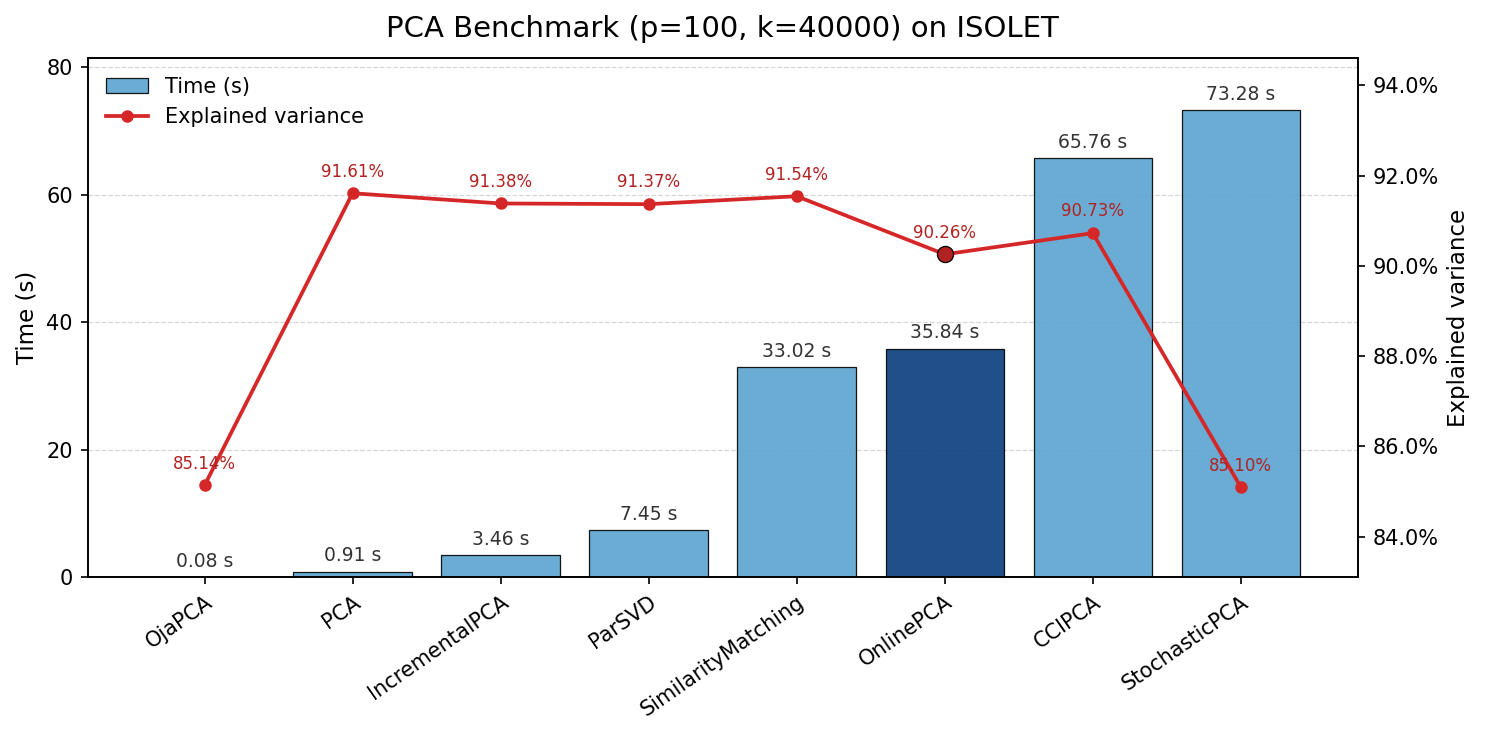

In [142]:
def plot_benchmark(results, p, g, *, highlight=None, order='given', rotation=28):
    methods = [r["method"] for r in results]
    times   = np.asarray([r["time"] for r in results], dtype=float)
    evrs    = np.asarray([r["explained_variance"] for r in results], dtype=float)

    if order == 'time':
        idx = np.argsort(times)
    elif order == 'evr':
        idx = np.argsort(-evrs)
    else:
        idx = np.arange(len(results))
    methods = [methods[i] for i in idx]; times = times[idx]; evrs = evrs[idx]

    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)
    ax2 = ax1.twinx()

    cmap = plt.get_cmap("Blues")
    bar_colors = [cmap(0.55)] * len(methods)
    edge_colors = ['none'] * len(methods)
    if highlight in methods:
        h_ix = methods.index(highlight)
        bar_colors[h_ix] = cmap(0.95)
        edge_colors[h_ix] = 'black'
    else:
        h_ix = None

    bars = ax1.bar(methods, times, color=bar_colors, edgecolor=edge_colors,
                   linewidth=0.6, alpha=0.9, label="Time (s)")

    # === make tallest bar reach 90% of axis height ===
    tmax = float(times.max()) if len(times) else 1.0
    if tmax > 0:
        ax1.set_ylim(0, tmax / 0.9)

    # === add "s" to the bar labels ===
    for b in bars:
        h = b.get_height()
        ax1.annotate(f'{h:.2f} s',
                     xy=(b.get_x() + b.get_width()/2, h),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom', fontsize=9, color='#333333')

    line, = ax2.plot(methods, evrs, marker='o', linewidth=1.8, markersize=5,
                     color='#D62728', label='Explained variance')
    if h_ix is not None:
        ax2.scatter([methods[h_ix]], [evrs[h_ix]], s=60, zorder=3,
                    facecolor='#B22222', edgecolor='black', linewidth=0.6)

    for x, y in zip(methods, evrs):
        ax2.annotate(f'{y:.2%}', (x, y), textcoords='offset points',
                     xytext=(0, 8), ha='center', fontsize=8, color='#B22222')

    ax1.set_ylabel("Time (s)", fontsize=11)
    ax2.set_ylabel("Explained variance", fontsize=11)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax2.set_ylim(max(0.0, evrs.min()-0.02), min(1.0, evrs.max()+0.03))

    ax1.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.5)
    ax1.set_axisbelow(True)

    plt.setp(ax1.get_xticklabels(), rotation=rotation,
             ha='right', rotation_mode='anchor')

    ax1.set_title(f"PCA Benchmark (p={p}, k={g}) on ISOLET", pad=10, fontsize=14)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, frameon=False, loc='upper left')

    fig.tight_layout()
    return fig, (ax1, ax2)

fig, (ax1, ax2) = plot_benchmark(results, p, g, highlight="OnlinePCA", order='given', rotation = 35) 
plt.savefig(f'plot_mixed_{g}_{p}_{n_samples}_2.pdf', bbox_inches='tight') 
plt.show()
